# Air Pollution Detection
## Project for ECE 228 SP25

## Install and import libraries

In [1]:
!pip install kaggle
!pip install -U datasets

In [2]:
from datasets import load_dataset, DatasetDict

In [7]:
!pip install -r requirements.txt

## Prepare dataset

In [3]:
# Download dataset

# Please upload your kaggle.json file
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download and unzip data file
!kaggle d download -q adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal
!unzip -q air-pollution-image-dataset-from-india-and-nepal.zip \
"Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP/*"

!mv "Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_NEP" .
!mv IND_and_NEP IMAGES
!rm -r "Air Pollution Image Dataset/" air-pollution-image-dataset-from-india-and-nepal.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adarshrouniyar/air-pollution-image-dataset-from-india-and-nepal
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)


In [3]:
import os
!pwd
!ls
print(os.listdir("IMAGES"))  # 应该输出多个子文件夹（类别名）

/content
IMAGES	kaggle.json  sample_data
['f_Severe', 'e_Very_Unhealthy', 'a_Good', 'b_Moderate', 'd_Unhealthy', 'c_Unhealthy_for_Sensitive_Groups']


In [4]:
# Load dataset
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="IMAGES")

# Shuffle dataset and split train and test parts
dataset = dataset.shuffle()
dataset = dataset['train'].train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/12240 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Using device: cuda


Resolving data files:   0%|          | 0/12240 [00:00<?, ?it/s]

Classes: ['a_Good', 'b_Moderate', 'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 'e_Very_Unhealthy', 'f_Severe']
Number of classes: 6


Map:   0%|          | 0/9792 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/15
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch: 20/77, Loss: 1.6243, Acc: 35.59%
Batch: 40/77, Loss: 1.3838, Acc: 46.62%
Batch: 60/77, Loss: 1.1798, Acc: 54.49%
Train Loss: 1.0384, Train Acc: 59.95%
Test Loss: 0.5304, Test Acc: 79.49%
Saved best model!

Epoch 2/15
----------
Batch: 20/77, Loss: 0.3799, Acc: 86.56%
Batch: 40/77, Loss: 0.3500, Acc: 86.80%
Batch: 60/77, Loss: 0.3303, Acc: 87.60%
Train Loss: 0.3164, Train Acc: 87.99%
Test Loss: 0.3828, Test Acc: 84.35%
Saved best model!

Epoch 3/15
----------
Batch: 20/77, Loss: 0.1664, Acc: 94.38%
Batch: 40/77, Loss: 0.1480, Acc: 94.82%
Batch: 60/77, Loss: 0.1446, Acc: 94.77%
Train Loss: 0.1402, Train Acc: 94.85%
Test Loss: 0.3149, Test Acc: 87.95%
Saved best model!

Epoch 4/15
----------
Batch: 20/77, Loss: 0.0927, Acc: 96.64%
Batch: 40/77, Loss: 0.0890, Acc: 96.80%
Batch: 60/77, Loss: 0.0804, Acc: 97.23%
Train Loss: 0.0820, Train Acc: 97.11%
Test Loss: 0.3105, Test Acc: 89.46%
Saved best model!

Epoch 5/15
----------
Batch: 20/77, Loss: 0.0661, Acc: 97.97%
Batch: 40/77, Loss: 

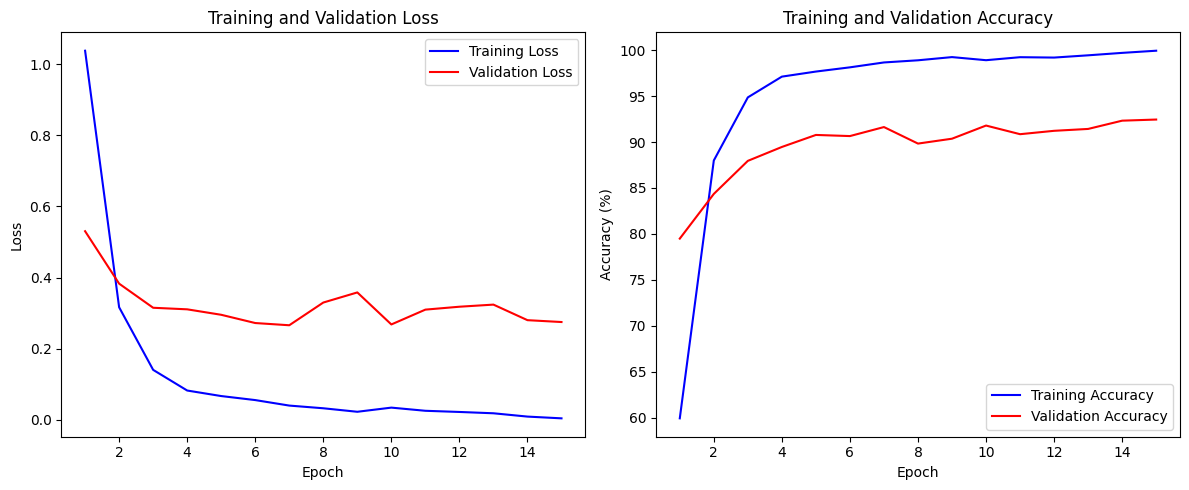

Final Test Accuracy: 92.44%


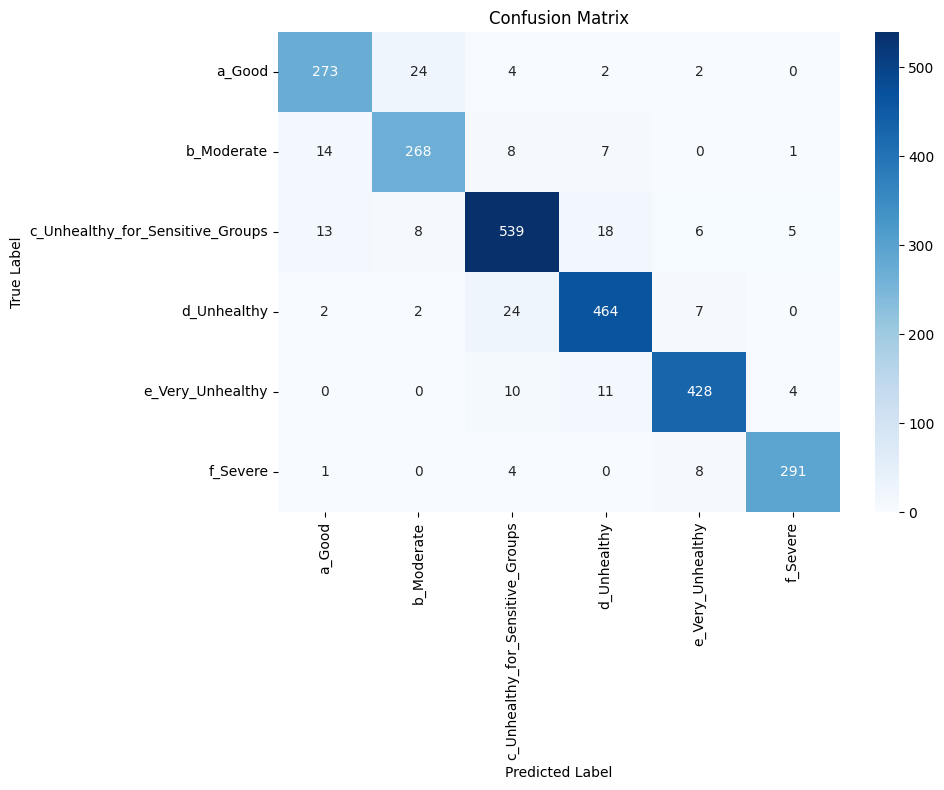

Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.90      0.90      0.90       305
                      b_Moderate       0.89      0.90      0.89       298
c_Unhealthy_for_Sensitive_Groups       0.92      0.92      0.92       589
                     d_Unhealthy       0.92      0.93      0.93       499
                e_Very_Unhealthy       0.95      0.94      0.95       453
                        f_Severe       0.97      0.96      0.96       304

                        accuracy                           0.92      2448
                       macro avg       0.92      0.92      0.92      2448
                    weighted avg       0.92      0.92      0.92      2448

Air pollution detection using ResNet completed!


In [9]:
# -*- coding: utf-8 -*-
"""
Air Pollution Detection using ResNet
Project for ECE 228 SP25
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from datasets import load_dataset, DatasetDict

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset (from the code you already have)
dataset = load_dataset("imagefolder", data_dir="IMAGES")
dataset = dataset.shuffle(seed=42)
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Print class information
print(f"Classes: {dataset['train'].features['label'].names}")
print(f"Number of classes: {len(dataset['train'].features['label'].names)}")

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transform function
def transform_image(examples):
    examples["pixel_values"] = [
        train_transforms(image.convert("RGB"))
        if torch.rand(1).item() < 0.75 else  # 75% chance to use train transforms
        test_transforms(image.convert("RGB"))
        for image in examples["image"]
    ]
    return examples

# Apply transformations
transformed_dataset = dataset.map(
    transform_image,
    batched=True,
    batch_size=16,
    remove_columns=["image"],
)

# Set format for PyTorch
transformed_dataset.set_format(type="torch", columns=["pixel_values", "label"])

# Create data loaders
train_loader = DataLoader(
    transformed_dataset["train"],
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    transformed_dataset["test"],
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Sample batch visualization
def visualize_batch(dataloader, num_images=5):
    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]

    # Convert from tensor to numpy for visualization
    images = images.permute(0, 2, 3, 1).cpu().numpy()

    # Denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    # Display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"Class: {dataset['train'].features['label'].names[labels[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Uncomment to visualize a batch
# visualize_batch(train_loader)

# Define ResNet model
class AirPollutionResNet(nn.Module):
    def __init__(self, num_classes):
        super(AirPollutionResNet, self).__init__()
        # Load pre-trained ResNet50
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Instantiate model
num_classes = len(dataset['train'].features['label'].names)
model = AirPollutionResNet(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(train_loader):
        inputs, targets = batch['pixel_values'].to(device), batch['label'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Print progress
        if (batch_idx + 1) % 20 == 0:
            print(f'Batch: {batch_idx + 1}/{len(train_loader)}, Loss: {running_loss / (batch_idx + 1):.4f}, Acc: {100 * correct / total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            inputs, targets = batch['pixel_values'].to(device), batch['label'].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Save predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    return test_loss, test_acc, all_preds, all_targets

# Training loop
def run_training(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=20):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Train
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate
        test_loss, test_acc, all_preds, all_targets = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # Update learning rate
        scheduler.step(test_loss)

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_resnet_model.pth')
            print('Saved best model!')

        print()

    # Load best model
    model.load_state_dict(torch.load('best_resnet_model.pth'))

    return model, train_losses, train_accs, test_losses, test_accs

# Run training
num_epochs = 15  # Adjust as needed
model, train_losses, train_accs, test_losses, test_accs = run_training(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs
)

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accs, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Final evaluation
final_test_loss, final_test_acc, all_preds, all_targets = evaluate_model(model, test_loader, criterion, device)
print(f'Final Test Accuracy: {final_test_acc:.2f}%')

# Create confusion matrix
class_names = dataset['train'].features['label'].names
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(all_targets, all_preds, target_names=class_names))

# Model explanation with Grad-CAM (optional)
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

# # Function to visualize Grad-CAM for a sample image
# def visualize_gradcam(model, image_tensor, label, class_names):
#     # Create GradCAM object
#     target_layer = model.resnet.layer4[-1]  # Last layer of ResNet
#     cam = GradCAM(model=model, target_layer=target_layer)

#     # Generate CAM
#     grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0))[0]

#     # Convert tensor to numpy image
#     image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
#     # Denormalize
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     image_np = std * image_np + mean
#     image_np = np.clip(image_np, 0, 1)

#     # Overlay CAM on image
#     cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

#     # Plot
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image_np)
#     plt.title(f'Original - Class: {class_names[label]}')
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.imshow(cam_image)
#     plt.title('Grad-CAM Visualization')
#     plt.axis('off')

#     plt.tight_layout()
#     plt.savefig('gradcam_example.png')
#     plt.show()

# Example usage (uncomment when needed):
# Sample image from test set
# sample_batch = next(iter(test_loader))
# image_tensor, label = sample_batch['pixel_values'][0].to(device), sample_batch['label'][0].item()
# visualize_gradcam(model, image_tensor, label, class_names)

# Function to predict pollution grade for a new image
def predict_image(model, image_path, class_names):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = test_transforms(image).unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = output.max(1)
        prob = torch.nn.functional.softmax(output, dim=1)[0]

    predicted_class = predicted.item()
    confidence = prob[predicted_class].item()

    print(f'Predicted class: {class_names[predicted_class]}')
    print(f'Confidence: {confidence:.2f}')

    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Example usage (uncomment when needed):
# from PIL import Image
# predict_image(model, 'path_to_image.jpg', class_names)

print("Air pollution detection using ResNet completed!")

In [10]:
!zip ResNet50.zip best_resnet_model.pth training_metrics.png confusion_matrix.png requirements.txt

  adding: best_resnet_model.pth (deflated 7%)
  adding: training_metrics.png (deflated 8%)
  adding: confusion_matrix.png (deflated 15%)
  adding: requirements.txt (deflated 28%)


In [11]:
from google.colab import drive
drive.mount('/content/drive')
!cp ResNet50.zip /content/drive/MyDrive/ECE228proj

Mounted at /content/drive
